# Data augmentation

* ref: https://github.com/vxy10/ImageAugmentation

In [4]:
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import matplotlib.gridspec as gridspec
import pickle
from tqdm import tqdm
import os
%matplotlib inline

In [2]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img, ang_range, shear_range, trans_range, brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values for affine transformation
    4- trans_range: Range of values for translation

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range) - ang_range/2  # set the angle between -ang_range/2 < x < ang_range/2
    rows,cols,ch = img.shape    
    """
    getRotationMatrix2D(Point2f center, double angle, double scale)
    * center: rotation center of input 
    * angle: rotation angel, the reference is the left top point, if it is positive
    * scale: scale rate, the output is a 2x3 matrix (affine matrix)
    """
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)
    return img

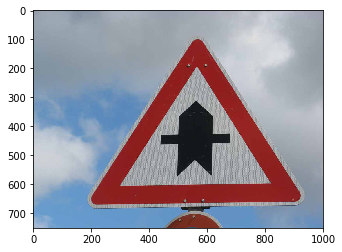

In [40]:
image = plt.imread("img//sample_traffic_sign.jpg")

#img = transform_image(image,20,10,5,brightness=1)
plt.imshow(image)

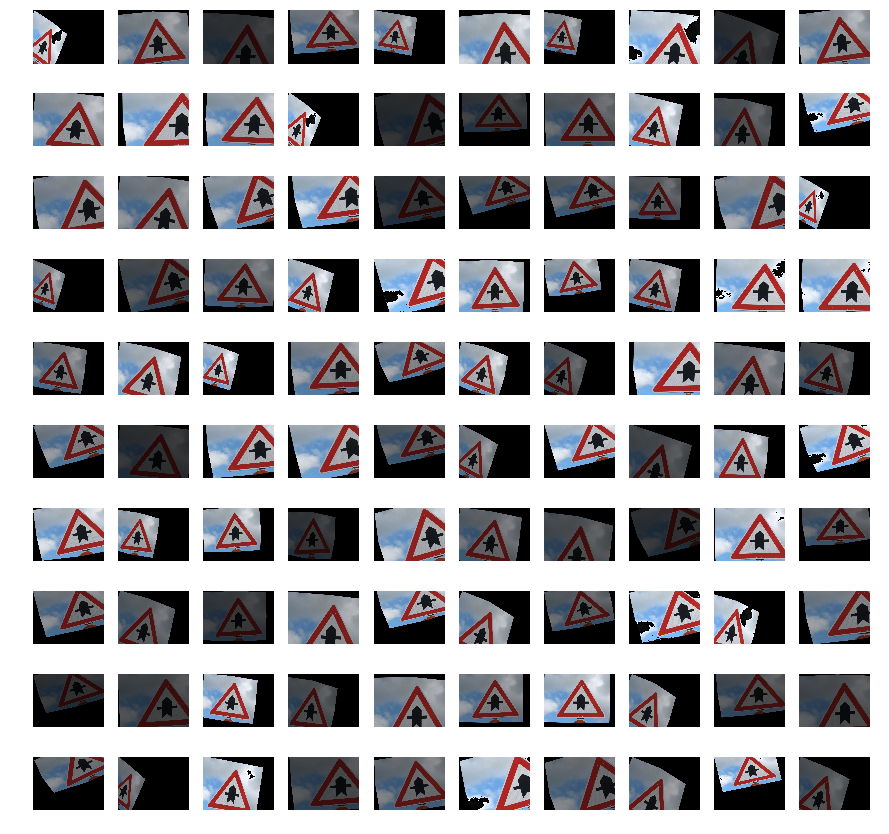

In [14]:
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(15,15))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,20,10,5,brightness=1)
    
    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Generate training data

In [5]:
data_rel_path = "..\\..\\..\\datasets_collection\\Traffic_Sign_Classifier"
training_file = os.path.join(data_rel_path, 'aug_train.p')
train = None
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

In [6]:
n_class = len(np.unique(train['labels']))
n_class

43

In [7]:
_, label_counter = np.unique(train['labels'], return_counts=True)
label_counter

array([ 600, 1980, 2010, 1260, 1770, 1650,  600, 1290, 1260, 1320, 1800,
       1170, 1890, 1920,  690,  600,  600,  990, 1080,  600,  600,  600,
        600,  600,  600, 1350,  600,  600,  600,  600,  600,  690,  600,
        609,  600, 1080,  600,  600, 1860,  600,  600,  600,  600], dtype=int64)

In [9]:
MINIMAL_IMAGES_COUNT=2000
pbar = tqdm(range(len(train['features'])), desc='Image', unit='images')
n_augment = 10
for i in pbar:
    cl=train['labels'][i]
    if label_counter[cl] < MINIMAL_IMAGES_COUNT:
        for j in range(n_augment):
            im = train['features'][i]
            img = transform_image(im,20,10,1)
            img = img.reshape(1,32,32,3)
            train['features']=np.concatenate((train['features'],img),axis=0)
            train['labels']=np.concatenate((train['labels'],[cl]))
        label_counter[cl]=label_counter[cl]+n_augment


Image: 100%|███████████████████████| 41469/41469 [1:14:31<00:00,  9.27images/s]


In [11]:
label_counter

array([2000, 2000, 2010, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
       2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
       2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
       2009, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000], dtype=int64)

# save data

In [10]:
data_rel_path = "..\\..\\..\\datasets_collection\\Traffic_Sign_Classifier"
aug_training_file = os.path.join(data_rel_path, 'aug_train_2000.p')
    
with open(aug_training_file, 'wb') as handle:
    pickle.dump(train, handle, protocol=pickle.HIGHEST_PROTOCOL)